In [1]:
import gpflow
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

/home/mt752/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mt752/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Data set

In [2]:
from numpy import genfromtxt
data = genfromtxt('../data/clean/motor.csv', delimiter=',', names=True)

In [3]:
data.dtype.names

('times', 'accel', 'strata', 'v')

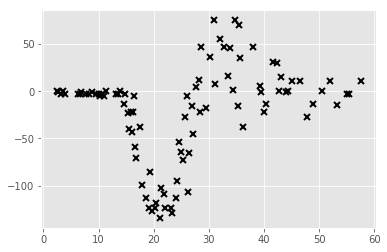

In [4]:
X = data["times"]
Y = data["accel"]
plt.plot(X, Y, 'kx', mew=2)

Construction of a **Gaussian Process Regression** model. 
Other models are:
* GPMC: Gaussian Process Model with MCMC posterior inference on parameters
* SVGP: Stochastic Variational GPs
* ...

In [5]:
k = gpflow.kernels.RBF(1)
m = gpflow.models.GPR(np.matrix(X).T, np.matrix(Y).T, kern=k)
m.kern.variance = 5.
m.kern.variance = 20.
m.likelihood.variance = 10.0
m.compile()

In [6]:
def plot(m, xstart, xend):
        
    xx = np.linspace(xstart, xend, 100)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(xstart, xend)

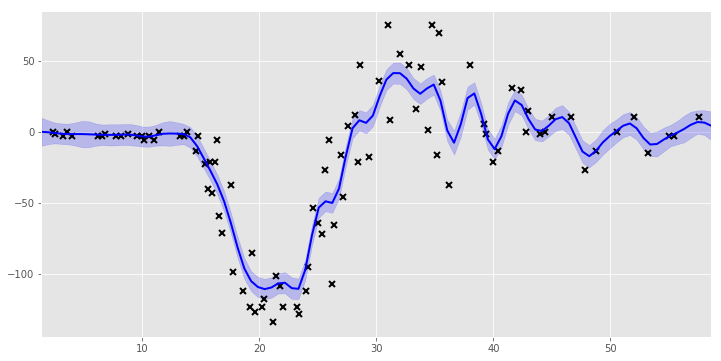

In [7]:
plot(m, np.min(X) - 1, np.max(X) + 1)

A compiled GP can be optimized using ML as follows:
```python
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m
```

# Product of Experts

In [12]:
experts = 20

# list of experts
poe = []

# splits (random in this case)
splitsPos = np.random.rand(experts-1) * np.max(X) + np.min(X)
splitsPos = np.sort(splitsPos)

print("Split positions: ", splitsPos)

Split positions:  [  9.92157692  17.21170047  24.23106581  24.53543782  26.70688433
  28.80792572  29.11488627  30.38114101  30.55452058  31.30749581
  31.95129697  37.77313745  38.64235045  41.72816761  42.30376654
  43.59711672  44.61620921  44.64975278  55.05266101]


### Training of Experts

In [13]:
for (startPos, endPos) in zip(np.hstack([np.min(X) - 1, splitsPos]), np.hstack([splitsPos, np.max(X) + 1])):
    print("Learning Expert for data between: ", startPos, " -> ", endPos)
    
    X_ = X[(X > endPos) & (X >= startPos)]
    Y_ = Y[(X > endPos) & (X >= startPos)]
    
    k = gpflow.kernels.RBF(1)
    m = gpflow.models.GPR(np.matrix(X_).T, np.matrix(Y_).T, kern=k)
    m.kern.variance = 5.
    m.kern.variance = 20.
    m.likelihood.variance = 10.0
    m.compile()
    poe.append(m)

Learning Expert for data between:  1.4  ->  9.92157692079
Learning Expert for data between:  9.92157692079  ->  17.2117004662
Learning Expert for data between:  17.2117004662  ->  24.2310658132
Learning Expert for data between:  24.2310658132  ->  24.5354378242
Learning Expert for data between:  24.5354378242  ->  26.7068843339
Learning Expert for data between:  26.7068843339  ->  28.8079257191
Learning Expert for data between:  28.8079257191  ->  29.1148862689
Learning Expert for data between:  29.1148862689  ->  30.3811410136
Learning Expert for data between:  30.3811410136  ->  30.5545205843
Learning Expert for data between:  30.5545205843  ->  31.3074958073
Learning Expert for data between:  31.3074958073  ->  31.9512969679
Learning Expert for data between:  31.9512969679  ->  37.7731374531
Learning Expert for data between:  37.7731374531  ->  38.642350449
Learning Expert for data between:  38.642350449  ->  41.728167607
Learning Expert for data between:  41.728167607  ->  42.30376

In [14]:
def plotPoE(M, xstart, xend):
    xx = np.linspace(xstart, xend, 100)[:,None]
    
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    
    ymean = np.zeros((len(xx), len(M)))
    yvar = np.zeros((len(xx), len(M)))

    for (mi, m) in enumerate(M):
        mean, var = m.predict_y(xx)
        ymean[:,mi] = mean[:,0]
        yvar[:,mi] = var[:,0]
            
    jointVar =  1 / np.sum(1 / yvar, 1)
    jointMean = jointVar * np.sum(np.divide(ymean, yvar), 1)
    
    plt.plot(xx, jointMean, 'b', lw=2)
    plt.fill_between(xx[:,0], jointMean - 2*np.sqrt(jointVar), jointMean + 2*np.sqrt(jointVar), color='blue', alpha=0.2)
    plt.xlim(xstart, xend)

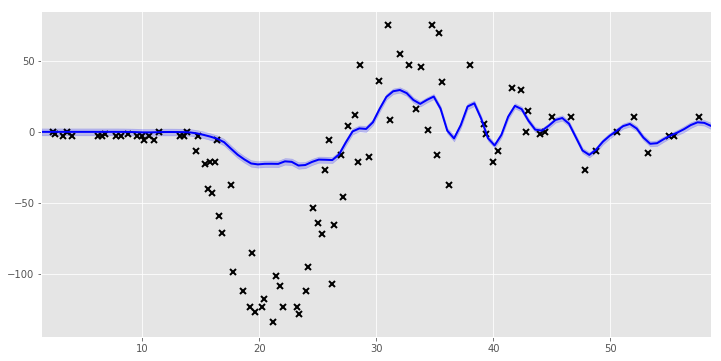

In [15]:
plotPoE(poe, np.min(X) - 1, np.max(X) + 1)

In [35]:
def plotMoE(M, splitsPos, xstart, xend):
    xx = np.linspace(xstart, xend, 100)[:,None]
    
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    
    ymean = np.zeros(len(xx))
    yvar = np.zeros(len(xx))

    c = 0
    for (startPos, endPos) in zip(np.hstack([xstart, splitsPos]), np.hstack([splitsPos, xend])):
        s = (xx[:,0] > endPos) & (xx[:,0] >= startPos)
        xx_ = xx[s,:]
        
        mean, var = M[c].predict_y(xx_)
        
        ymean[s] = mean[:,0]
        yvar[s] = var[:,0]
        c += 1
                
    plt.plot(xx, ymean, 'b', lw=2)
    plt.fill_between(xx[:,0], ymean - 2*np.sqrt(yvar), ymean + 2*np.sqrt(yvar), color='blue', alpha=0.2)
    plt.xlim(xstart, xend)

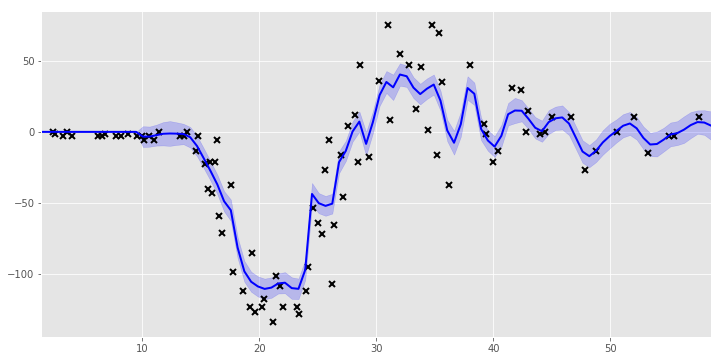

In [36]:
plotMoE(poe, splitsPos, np.min(X) - 1, np.max(X) + 1)

# mixture of MoE

In [49]:
K = 5
experts = 20

# list of experts
poe = [[]]
allSplitsPos = []

for k in range(K):
    # splits (random in this case)
    splitsPos = np.random.rand(experts-1) * np.max(X) + np.min(X)
    splitsPos = np.sort(splitsPos)
    allSplitsPos.append(splitsPos)

    print("Split positions: ", splitsPos)

Split positions:  [  3.38643301   3.70747656   4.2184575    8.55963493  11.13991739
  18.2903983   20.94812211  23.2542155   27.60867252  33.2913727
  34.44184102  35.74613704  40.5858945   40.63092624  45.45785517
  46.75120927  50.93065166  54.05991458  58.32738269]
Split positions:  [ 11.59039464  14.52249737  17.78458151  20.89166351  23.88449034
  24.99243587  27.77802859  32.71491534  32.87871577  36.40316221
  42.80448691  45.28047537  45.4463723   45.60370431  45.77628069
  48.40191588  52.26427171  56.62360107  57.0308041 ]
Split positions:  [  3.05364725   9.63339025  20.13355691  20.53375936  25.92609665
  26.83475303  27.91875962  28.62568516  29.54030208  33.2541322
  37.19476559  45.63564794  49.78692514  51.38707024  52.04981543
  53.43048909  53.51885589  55.91250238  55.99221811]
Split positions:  [  4.3174111    7.17408258   9.29226342  10.69295714  13.26967968
  17.39599511  18.03509834  18.50879294  27.23787579  28.14917689
  34.07761634  36.87377363  40.26407734  4

### Training of Experts


In [50]:
for k in range(K):
    ppoe = []
    splitsPos = allSplitsPos[k]
    for (startPos, endPos) in zip(np.hstack([np.min(X) - 1, splitsPos]), np.hstack([splitsPos, np.max(X) + 1])):
        print("Learning Expert for data between: ", startPos, " -> ", endPos)
    
        X_ = X[(X > endPos) & (X >= startPos)]
        Y_ = Y[(X > endPos) & (X >= startPos)]
    
        k = gpflow.kernels.RBF(1)
        m = gpflow.models.GPR(np.matrix(X_).T, np.matrix(Y_).T, kern=k)
        m.kern.variance = 5.
        m.kern.variance = 20.
        m.likelihood.variance = 10.0
        m.compile()
        ppoe.append(m)
    poe.append(ppoe)

Learning Expert for data between:  1.4  ->  3.38643300558
Learning Expert for data between:  3.38643300558  ->  3.70747655811
Learning Expert for data between:  3.70747655811  ->  4.21845750399
Learning Expert for data between:  4.21845750399  ->  8.55963492998
Learning Expert for data between:  8.55963492998  ->  11.1399173946
Learning Expert for data between:  11.1399173946  ->  18.2903982983
Learning Expert for data between:  18.2903982983  ->  20.9481221083
Learning Expert for data between:  20.9481221083  ->  23.2542155005
Learning Expert for data between:  23.2542155005  ->  27.6086725155
Learning Expert for data between:  27.6086725155  ->  33.2913727049
Learning Expert for data between:  33.2913727049  ->  34.4418410155
Learning Expert for data between:  34.4418410155  ->  35.7461370355
Learning Expert for data between:  35.7461370355  ->  40.585894504
Learning Expert for data between:  40.585894504  ->  40.6309262432
Learning Expert for data between:  40.6309262432  ->  45.457

In [51]:
def plotSMoE(allM, allSplitsPos, K, xstart, xend):
    xx = np.linspace(xstart, xend, 100)[:,None]
    
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    
    ymean = np.zeros((len(xx), K))
    yvar = np.zeros((len(xx), K))

    for k in range(K):
        c = 0
        M = allM[k+1]
        splitsPos = allSplitsPos[k]
        for (startPos, endPos) in zip(np.hstack([xstart, splitsPos]), np.hstack([splitsPos, xend])):
            s = (xx[:,0] > endPos) & (xx[:,0] >= startPos)
            xx_ = xx[s,:]
        
            mean, var = M[c].predict_y(xx_)
        
            ymean[s,k] = mean[:,0]
            yvar[s, k] = var[:,0]
            c += 1
                
    ymean = np.mean(ymean, 1)
    yvar = np.mean(yvar, 1)
    
    plt.plot(xx, ymean, 'b', lw=2)
    plt.fill_between(xx[:,0], ymean - 2*np.sqrt(yvar), ymean + 2*np.sqrt(yvar), color='blue', alpha=0.2)
    plt.xlim(xstart, xend)

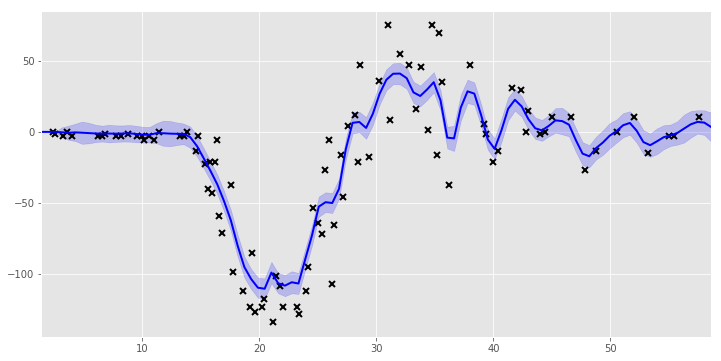

In [52]:
plotSMoE(poe, allSplitsPos, K, np.min(X) - 1, np.max(X) + 1)